# Lab3 - Pool Active Learning

In this scenario we will look into pool based active learning. We will implement a simple evaluation loop, and look into pool based uncertainty measures.

To simulate active learning problem we will as usuall use already labeled dataset and "forget" the labels for majority of data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from sklearn.datasets import fetch_openml
X, Y = fetch_openml('nomao', return_X_y=True) 

Lets get some insight about this data.

In [ ]:
Y.head()

0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: category
Categories (2, object): ['1', '2']

(array([24621.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  9844.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

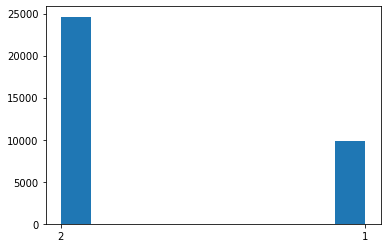

In [ ]:
plt.hist(Y) # Of course we couldn't do that in practice, although we can usually ask domain experts about number of unique classes and their priors

In [ ]:
X.describe()

,V1,V2,V3,V4,V5,V6,V9,V10,V11,V12,...,V106,V107,V109,V110,V111,V113,V114,V115,V117,V118
count,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,...,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000,34465.000000
mean,0.636477,0.494806,0.626273,0.560947,0.534202,0.506693,0.860946,0.821590,0.883386,0.854119,...,0.765575,0.628865,0.978679,0.607880,0.396168,0.982576,0.644336,0.438054,0.988839,0.979322
std,0.424382,0.380142,0.305667,0.369695,0.325744,0.372908,0.203808,0.210159,0.149473,0.181257,...,0.234591,0.346032,0.070081,0.137677,0.172149,0.064814,0.123862,0.156237,0.086640,0.084597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.100000,0.000000,0.008755,0.000000,0.000000,0.020058,0.000000,0.000000,0.000064,0.000077
25%,0.000000,0.000000,0.361111,0.218750,0.240000,0.139535,0.860946,0.821590,0.883386,0.854119,...,0.600000,0.294118,0.978679,0.607880,0.357143,0.982576,0.644336,0.400000,0.999992,0.979322
50%,1.000000,0.500000,0.666667,0.666667,0.473684,0.478261,0.860946,0.821590,0.883386,0.854119,...,0.700000,0.466667,0.978679,0.607880,0.396168,0.982576,0.644336,0.438054,1.000000,0.979322
75%,1.000000,1.000000,1.000000,1.000000,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.999457,0.607880,0.396168,0.999653,0.644336,0.438054,1.000000,0.999999
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34465 entries, 0 to 34464
Columns: 118 entries, V1 to V118
dtypes: category(29), float64(89)
memory usage: 24.4 MB


In [11]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118
0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,2,2,0.860946,0.82159,...,0.999967,0.750000,0.500000,2,0.999953,0.777778,0.461538,2,1.0,1.000000
1,1.0,0.75,0.857143,0.857143,0.894737,0.947368,2,1,0.860946,0.82159,...,0.999807,0.500000,0.307692,2,0.999983,0.538462,0.437500,2,1.0,1.000000
2,1.0,1.00,1.000000,1.000000,1.000000,1.000000,2,2,0.860946,0.82159,...,0.999983,0.666667,0.461538,2,0.999993,0.800000,0.666667,2,1.0,1.000000
3,1.0,0.75,0.857143,0.857143,0.842105,0.833333,2,1,1.000000,1.00000,...,0.998023,0.500000,0.285714,2,0.998605,0.555556,0.384615,2,1.0,0.999994
4,0.0,0.00,0.250000,0.000000,0.250000,0.000000,1,1,0.860946,0.82159,...,0.978679,0.607880,0.396168,1,0.982576,0.644336,0.438054,1,1.0,0.979322


In [ ]:
X.isna().sum().sum()

0

Data set has 118 features, some of them are categorical most of them are numerical and already looks like they are scaled to [0, 1] range. There are no missing values in the dataset.

Predicted variable has 2 categories indicated with 1 and 2. The problem is unbalanced, occurence of one class is dominating the other.

1. Sample 1% of the data as an initally labeled data set part. Sample 40% of the dataset for evaluation of created methods.(How we can evaluate the methods in practice?)

2. Create a classifier and train it on this initial data set part. Evaluate it using BAC metric.(since problem is unbalanced)

3. Implement the following informativeness functions:

In [ ]:
def entropy_informativeness(predictions_probabilities: np.ndarray) -> np.ndarray:
  #TODO
  pass

def margin_informativeness(predictions_probabilities: np.ndarray) -> np.ndarray:
  #TODO
  pass

def random_informativeness(predictions_probabilities: np.ndarray) -> np.ndarray:
  #TODO
  pass


4. Implement a function that performs an active learning experiment and works as follows: \
  Repeat until 2% of data is tagged:
  1. Trains model using current training data set.
  2. Makes predictions using current model on the available training pool.
  3. Computes chosen informativeness on the predictions of the model.
  4. Selects best sample based on informativeness and retrives its labels simulating that it was passed to experts and add it to the training phase.

Evaluate the final model using BAC on the evaluation set.

Note. Try to make your active learning loop in an extendable way, we will be adding additional elements to this loop in next classes.


Evaluate different informativeness functions in this setup.


5.* Extend the loop to the generic basic active learning framework. It may work as follows:
1. Chooses the initial training data set(of size `init_batch`) to be labelled according the tactic from the parameter.(Random sampling by default)
2. Until the end of labelling budget: \
  a. Evaluates all samples in the pool using provided informativeness function. (function as a parameter)\
  b. Chooses samples basing on the evaluations.(Chooser as a parameter )\
  c. Retrieves labels for the chosen samples. (Labelling should be redefinable for further function extensions) \
  d. Retraines/fine tunes the machine learning model. \
  e. Evaluates the current model with passed metric functions.
3. Returns the created final model and evaluation functions obtained during the loop.

Try to set the defualt parameters. So that we can run an experiment passing mainly the data. 